# Project part 3

## Installs and imports

In [1]:
%pip install Wikidata
%pip install NetworkX

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:

import os
import tarfile
import datetime
import random
import json
import itertools
import requests
import scipy

import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns 

from statistics import mean
from sklearn.metrics import jaccard_score
from wikidata.client import Client
from scipy.sparse import coo_array

from tqdm.auto import tqdm, trange

## Data loading and preprocessing 


In [2]:
DATA_FOLDER = 'data'
DB_FOLDER_NAME = 'MovieSummaries'
MOVIE_TABLE_PATH = os.path.join(DATA_FOLDER, DB_FOLDER_NAME, 'movie.metadata.tsv')
CHARACTER_TABLE_PATH = os.path.join(DATA_FOLDER, DB_FOLDER_NAME, 'character.metadata.tsv')
IMDB_FINAL_TABLE_PATH = os.path.join(DATA_FOLDER, 'imdb.ratings.tsv')


movies_columns = ['wikipedia movie id',
                  'freebase movie id',
                  'movie name',
                  'movie release date',
                  'movie box office revenue',
                  'movie runtime',
                  'movie languages',
                  'movie countries',
                  'movie genres']

characters_columns = ['wikipedia movie id',
                      'freebase movie id',
                      'movie release date',
                      'character name',
                      'actor dob',
                      'actor gender',
                      'actor height',
                      'actor ethnicity',
                      'actor name',
                      'actor age at movie release',
                      'freebase character/actor map id',
                      'freebase character id',
                      'freebase character map']

# Extract character.metadata.tsv and movie.metadata.tsv tables from MovieSummaries

file = tarfile.open(os.path.join(DATA_FOLDER, DB_FOLDER_NAME + '.tar.gz'))
file.extractall(DATA_FOLDER)
file.close()

df_movie = pd.read_csv(MOVIE_TABLE_PATH, sep ='\t', header = None,\
    names=movies_columns, na_values=['{}', ' '], lineterminator='\n')
df_character = pd.read_csv(CHARACTER_TABLE_PATH, sep ='\t', header = None,\
    names=characters_columns, na_values=' ', lineterminator='\n')

# Extract imdb table

df_movies_IMDb_ratings = pd.read_csv(IMDB_FINAL_TABLE_PATH, sep ='\t',\
    na_values = ['{}', ' '], lineterminator='\n')


### Movie table preprocessing

In [3]:
# For movie and character identification we decided to use wikipedia id, so
# information from freebase are not usefull for us. We can remove columns regarding freebase.
df_movie = df_movie.drop(['freebase movie id'], 1)

# In our project we need movie release dates, so we can drop movies without release date.
# We drop only about 8 percent of movies.
print('Original number of movies: ', len(df_movie))
df_movie = df_movie.dropna(subset=['movie release date'])
print('Number of movies after droping empty dates: ', len(df_movie))

# Clean some columns which have freebase ID number apart from valuable information
def cleaning_function(column):
    string_cleaner = lambda val: ','.join(list(json.loads(val).values()))
    return [string_cleaner(val) if isinstance(val, str) else 'None' for val in column]

df_movie['movie languages'] = cleaning_function(df_movie['movie languages'])
df_movie['movie countries'] = cleaning_function(df_movie['movie countries'])
df_movie['movie genres'] = cleaning_function(df_movie['movie genres'])

# Clean date column, keep dates as just years of type int
def date_cleaning_function(column):
    string_cleaner = lambda val: val if len(val) <= 4 else val[0:4]
    dates = [string_cleaner(str(date)) for date in column]
    return np.array(dates, dtype=int)

df_movie['movie release date'] = date_cleaning_function(df_movie['movie release date'])

MINIMUM_RELEASE_DATE = 1888 # Roundhay Garden Scene was the first motion picture, release in 1888
df_movie = df_movie[df_movie['movie release date'] >= MINIMUM_RELEASE_DATE]
print('Number of movies after droping too early release date: ', len(df_movie))

MAXIMUM_RUNTIME = 1200 # Movie longer then 20h is some anomaly
df_movie = df_movie[(df_movie['movie runtime'].isnull()) | (df_movie['movie runtime'] <= MAXIMUM_RUNTIME)]
print('Number of movies after droping too long movies: ', len(df_movie))


/tmp/ipykernel_184700/1429770609.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_movie = df_movie.drop(['freebase movie id'], 1)


Original number of movies:  81741
Number of movies after droping empty dates:  74839
Number of movies after droping too early release date:  74838
Number of movies after droping too long movies:  74825


In [4]:
df_movie.head()

,wikipedia movie id,movie name,movie release date,movie box office revenue,movie runtime,movie languages,movie countries,movie genres
0,975900,Ghosts of Mars,2001,14010832.0,98.0,English Language,United States of America,"Thriller,Science Fiction,Horror,Adventure,Supe..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,English Language,United States of America,"Mystery,Biographical film,Drama,Crime Drama"
2,28463795,Brun bitter,1988,NaN,83.0,Norwegian Language,Norway,"Crime Fiction,Drama"
3,9363483,White Of The Eye,1987,NaN,110.0,English Language,United Kingdom,"Thriller,Erotic thriller,Psychological thriller"
4,261236,A Woman in Flames,1983,NaN,106.0,German Language,Germany,Drama


### Character table preprocessing

In [5]:
# For character identification we decided to use wikipedia id, so
# information from freebase are not usefull for us. We can remove columns regarding freebase.
df_character = df_character.drop(['freebase movie id', 'freebase character/actor map id', 'freebase character id', 'freebase character map'], 1)

# Movie release date is used from df_movie dataframe, so it can be removed in df_character
df_character = df_character.drop(['movie release date'], 1)

# Character names are not really usefull for us in this analysis, as we built actor graph not character graph
df_character = df_character.drop(['character name'], 1)

# In out project we need actor names, so we can drop character without their, actors name.
# We drop less then 1 percent of characters.
print('Original number of characters: ', len(df_character))
df_character = df_character.dropna(subset=['actor name'])
print('Number of characters after droping empty actor names: ', len(df_character))


/tmp/ipykernel_184700/3195656742.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_character = df_character.drop(['freebase movie id', 'freebase character/actor map id', 'freebase character id', 'freebase character map'], 1)
/tmp/ipykernel_184700/3195656742.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_character = df_character.drop(['movie release date'], 1)
/tmp/ipykernel_184700/3195656742.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_character = df_character.drop(['character name'], 1)


Original number of characters:  450669
Number of characters after droping empty actor names:  449441


Ethnicities retrieving 

In [6]:
WIKIDATA_QUERY = """
SELECT DISTINCT ?item ?itemLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    SELECT DISTINCT ?item WHERE {
      ?item p:P646 ?statement0.
      ?statement0 (ps:P646) "%s".
    }
    LIMIT 100
  }
}
"""

def get_ethnicity(ethnicity_freebase_id):
    """Get the label of the freebase ID from Wikidata

    Args:
        freebase_id: the freebase ID to be decoded

    Returns: 
        entity.label, the corresponding label of the Wikidata ID
    """

    query = WIKIDATA_QUERY % ethnicity_freebase_id
    req = requests.get("https://query.wikidata.org/sparql",
                      params={"format": "json", "query": query})
    try:
        data = req.json()
        wikidata_id = data["results"]["bindings"][0]["itemLabel"]["value"]
    except:
        return np.nan

    return str(Client().get(wikidata_id, load=True).label)

def ethnicities_decoded(column):
    ethnicities = column.dropna().unique()
    print(f'We have {len(ethnicities)} unique ethnicities in actor table')
    decoded = []
    for ethnicity in tqdm(ethnicities):
        decoded.append(get_ethnicity(ethnicity))
    translator = dict(zip(ethnicities, decoded))
    return column.replace(translator)

df_character['actor ethnicity'] = ethnicities_decoded(df_character['actor ethnicity'])
ethnicity_found = df_character['actor ethnicity'].count()
print(f'After retrieving actor ethnicities we have {ethnicity_found} out of\
{len(df_character)} character ethnicities - so about {100 * ethnicity_found // len(df_character)} percent')

We have 479 unique ethnicities in actor table


  0%|          | 0/479 [00:00<?, ?it/s]

After retrieving actor ethnicities we have 64923 out of449441 character ethnicities - so about 14 percent


In [7]:
df_character.head()

,wikipedia movie id,actor dob,actor gender,actor height,actor ethnicity,actor name,actor age at movie release
0,975900,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0
1,975900,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0
2,975900,1969-06-15,M,1.727,African Americans,Ice Cube,32.0
3,975900,1967-09-12,M,1.750,NaN,Jason Statham,33.0
4,975900,1977-09-25,F,1.650,NaN,Clea DuVall,23.0


### IMDB tables integration into movies table

In [8]:
print(f'Number of movies before integrating with IMDB ratings: {len(df_movie)}')
df_movie = df_movie.merge(df_movies_IMDb_ratings, how ='inner', on=['movie name'])
df_movie = df_movie.drop_duplicates(subset = 'wikipedia movie id')
print(f'Number of movies after integrating with IMDB ratings: {len(df_movie)}')

# Rename columns to keep the naming convention
df_movie = df_movie.rename(columns={'averageRating': 'average rating', 'numVotes': 'num votes'})

df_movie.head() 

Number of movies before integrating with IMDB ratings: 74825
Number of movies after integrating with IMDB ratings: 53173


,wikipedia movie id,movie name,movie release date,movie box office revenue,movie runtime,movie languages,movie countries,movie genres,average rating,num votes
0,975900,Ghosts of Mars,2001,14010832.0,98.0,English Language,United States of America,"Thriller,Science Fiction,Horror,Adventure,Supe...",4.9,55427
2,28463795,Brun bitter,1988,NaN,83.0,Norwegian Language,Norway,"Crime Fiction,Drama",5.7,40
3,13696889,The Gangsters,1913,NaN,35.0,"Silent film,English Language",United States of America,"Short Film,Silent film,Indie,Black-and-white,C...",6.8,16
4,23070193,The Gangsters,1956,NaN,NaN,French Language,France,Comedy film,6.8,16
5,18998739,The Sorcerer's Apprentice,2002,NaN,86.0,English Language,South Africa,"Family Film,Fantasy,Adventure,World cinema",6.5,160


## Features analysis and visualization

To give some background on what, features of characters and movies tables we found useful, and decided to include in final analysis, we present few statistics about the features.

In [9]:
def present_column_usefullnes(df):
    print('Size of the whole dataframe: ', len(df))
    for column in df.columns:
        percentage = 100 * df[column].count() // len(df)
        print(f'Percentage of non-nan values in {column} column: \t{percentage} ')
    print('')

present_column_usefullnes(df_character)
present_column_usefullnes(df_movie)

Size of the whole dataframe:  449441
Percentage of non-nan values in wikipedia movie id column: 	100 
Percentage of non-nan values in actor dob column: 	76 
Percentage of non-nan values in actor gender column: 	90 
Percentage of non-nan values in actor height column: 	34 
Percentage of non-nan values in actor ethnicity column: 	14 
Percentage of non-nan values in actor name column: 	100 
Percentage of non-nan values in actor age at movie release column: 	65 

Size of the whole dataframe:  53173
Percentage of non-nan values in wikipedia movie id column: 	100 
Percentage of non-nan values in movie name column: 	100 
Percentage of non-nan values in movie release date column: 	100 
Percentage of non-nan values in movie box office revenue column: 	14 
Percentage of non-nan values in movie runtime column: 	82 
Percentage of non-nan values in movie languages column: 	100 
Percentage of non-nan values in movie countries column: 	100 
Percentage of non-nan values in movie genres column: 	100 
P

We see, that we can make some observation about corelation between actors' careers and their characteristics as age during movie release or age. Then height and ethnicity is not that common in our table.

For movies, we see, that percentage of movies for which box office ravenue is present in the table is rather low. That is the reason why we decided to use IMDb tables, to measure movies 'success' also by how highly rated they are. 

Now, we want to observe distribution of few, interesting features from movies table.

  0%|          | 0/3 [00:00<?, ?it/s]

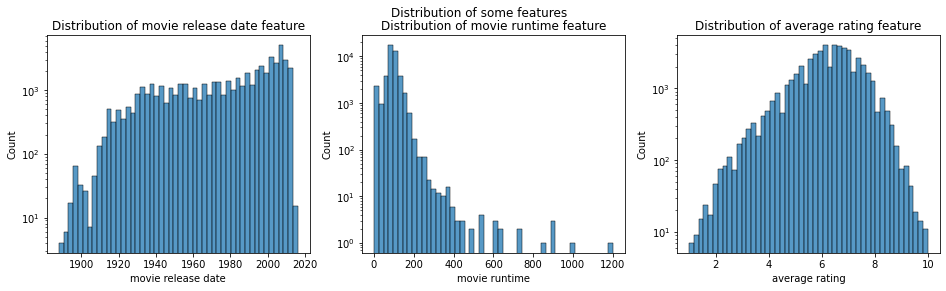

In [10]:
def plot_features_distribution(df, features):
    fig, ax = plt.subplots(1, len(features), figsize=(16,4))
    for i, feature in enumerate(tqdm(features)):
        sns.histplot(df[feature], log_scale=(False, True), bins=50, ax=ax[i])
        # ax[i].hist(df[feature], bins=50)
        # ax[i].set_yscale("log")
        ax[i].set_title(f'Distribution of {feature} feature')
    fig.suptitle(f'Distribution of some features', fontsize=12)
    
plot_features_distribution(df_movie, ['movie release date', 'movie runtime', 'average rating'])

Average movie rating distribution looks quite nice, like it is a normal distribution. From this, we can deduct, that actors' rating distribution looks similar. We will use this fact, together with the knowledge of average rating among actors.

## Graph construction

In [11]:
class GraphWrapper:
    '''
        Wrapper for networkx graph class, helps to make required operations easier

        The general idea of this wrapper is that, we load the whole graph while initializing
        and save it as 'graph_general' (not really whole, because we can specify years 
        of movies that interest us). Then, we have a part of the whole graph on which we want
        to focus - 'graph_part', it is a subgraph on 'graph_general' with all its nodes and
        its edges representing movies released in [tw_start, tw_start + tw_length - 1].

        So 'graph_part' is a part of 'graph_general' existing in specified time window. All
        other operations are made on 'graph_part'.
    
    '''

    def __init__(self, df_character, df_movie, release_year_min, release_year_max):
        self.graph_general = nx.Graph()
        self.graph_part = nx.Graph() # Graph used for sliding time window
        
        # Information on what movies do we keep in the graph_general
        self.release_year_min = release_year_min
        self.release_year_max = release_year_max

        # Information on what time window is graph_part focused on
        self.tw_start = 0
        self.tw_length = 0

        # Build graph_general nodes
        self.graph_general.add_nodes_from(df_character['actor name'].unique())

        # Add rating property to graph nodes
        attr = {node:{} for node in self.graph_general.nodes}
        nx.set_node_attributes(self.graph_general, attr, name='rating')

        # Build edges of graph_general
        for _, movie in tqdm(df_movie.iterrows(), total=len(df_movie)):
            wiki_movie_id = movie['wikipedia movie id']
            movie_release_date = movie['movie release date']
            movie_rating = movie['average rating']
            if not release_year_min <= movie_release_date <= release_year_max:
                continue # Year outside of bounds
            
            connected = df_character[df_character['wikipedia movie id'] == wiki_movie_id]['actor name'].unique()
            for node in connected:
                self.graph_general.nodes[node]['rating'][movie_release_date] = movie_rating
            attributes = {'date': movie_release_date}
            new_edges = [(actor1, actor2, attributes) for actor1 in connected for actor2 in connected]
            self.graph_general.add_edges_from(new_edges)

        # Remove nodes with degree 0 from graph_general
        nodes_to_remove = list(filter(lambda entry: entry[1] == 0, self.graph_general.degree))
        nodes_to_remove = [node for node, _ in nodes_to_remove]
        self.graph_general.remove_nodes_from(nodes_to_remove)

        # Add some properties to graph nodes
        actors_movie_count = df_character['actor name'].groupby(df_character['actor name']).agg('count')
        nx.set_node_attributes(self.graph_general, actors_movie_count, name='movie count')

        actors_first_movie = {}
        actors_last_movie = {}
        for node in self.graph_general.nodes:
            actors_first_movie[node] = min([attr['date'] for attr in self.graph_general[node].values()])
            actors_last_movie[node] = max([attr['date'] for attr in self.graph_general[node].values()])
        nx.set_node_attributes(self.graph_general, actors_first_movie, name='first release')
        nx.set_node_attributes(self.graph_general, actors_last_movie, name='last release')

        # Build graph_part nodes
        self.graph_part.add_nodes_from(self.graph_general)

    def focus_on_tw(self, tw_start, tw_length):
        self.tw_start = int(tw_start)
        self.tw_length = tw_length
        self.graph_part = nx.create_empty_copy(self.graph_general)

        for actor1, actor2, attr in self.graph_general.edges(data=True):
            if tw_start <= attr['date'] < tw_start + tw_length:
                self.graph_part.add_edge(actor1, actor2, date=attr['date'])

    def move_tw(self):
        '''
            Moving time window by 1 year.

            It is recommended to use this function to move time window by 1 year, instead of
            using 'focus_on_tw' with higher tw_start, as this one performs only the neccecary 
            modification of 'graph_part' edges.
        '''

        self.tw_start += 1
        
        edges_to_remove = list(filter(lambda x: x[2]['date'] == self.tw_start - 1, self.graph_part.edges(data=True)))
        self.graph_part.remove_edges_from(edges_to_remove)
    
        edges_to_add = list(filter(lambda x: x[2]['date'] == self.tw_start + self.tw_length - 1,\
            self.graph_general.edges(data=True)))
        self.graph_part.add_edges_from(edges_to_add)

    def k_neighborhood(self, node, k):
        ''' 
            Returns all nodes distant 'k' or less from 'node' in 'graph_part'

            This function has crazy high complexity with k, but we use
            it only with small values of k (<= 3)
        '''

        nodes = set([node])
        for step in range(k):
            new_nodes = set()
            for node in nodes:
                new_nodes = new_nodes.union(self.graph_part[node])
            nodes = new_nodes
        return nodes

    def k_neighborhoods(self, nodes, k):
        '''
            Returns dict, from node (in 'nodes') to its k-distant neighberhood
        '''

        result = {node: self.k_neighborhood(node, k) for node in nodes}
        return result

    def get_actor_rating(self, actor, year):
        '''
            We define actor's rating of fiven year as rating of a movie he played it 
            the closest (timewise) to this year. If actor didn't play in any movies in [-10 +10 years]
            then his rating is 0
        '''

        ratings = self.graph_general.nodes[actor]['rating']
        max_distance = 10
        distance = 0
        
        for distance in range(max_distance + 1):
            if year + distance in ratings:
                return ratings[year + distance]
            if year - distance in ratings:
                return ratings[year - distance]
        return 0

    def get_actor_group_rating(self, actors, year):
        '''
            Return mean rating from all the actors in the group
        '''

        return mean([self.get_actor_rating(actor, year) for actor in actors])

    def get_actor_rating_smooth(self, actor, year, radius):
        '''
            Returns mean from actor's ratings on interval [year - radius, year + radius]
            For radius = 0 its equivalent to get_actor_rating
        '''

        return mean([self.get_actor_rating(actor, year1) for year1 in range(year - radius, year + radius + 1)])


In [12]:
# FOR PERFORMANCE REASONS USE ONLY EDGES CREATED BY MOVIES RELEASED IN CERTAIN YEARS
RELEASE_YEAR_MIN = 1980
RELEASE_YEAR_MAX = 2010

gw = GraphWrapper(df_character, df_movie, RELEASE_YEAR_MIN, RELEASE_YEAR_MAX)


  0%|          | 0/53173 [00:00<?, ?it/s]

## Graph analysis

#### General graph properties 
We want to know a little more about the general graph properties and also how the number of edges change through the years.

Whole graph built from movies released between 1980 and 2010
Number of nodes in whole graph:  75276
Number of edges in whole graph:  1225724


  0%|          | 0/31 [00:00<?, ?it/s]

KeyboardInterrupt: 

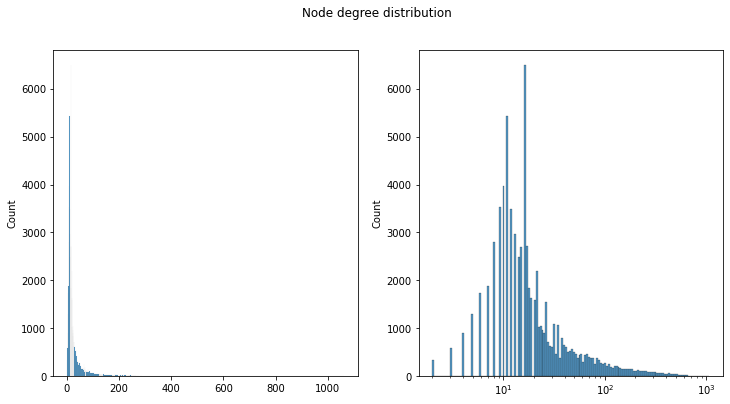

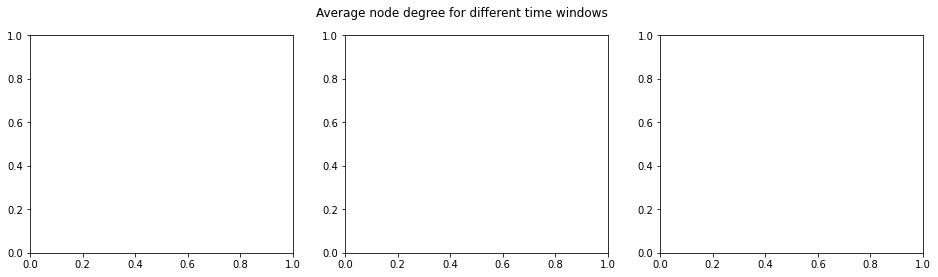

In [13]:
def plot_degree_distribution(gw):
    degrees = [deg for _, deg in gw.graph_general.degree]

    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    sns.histplot(degrees, ax=ax[0])
    sns.histplot(degrees, log_scale=True, ax=ax[1])
    fig.suptitle(f'Node degree distribution', fontsize=12)

def plot_tw_number_of_edges(gw, tw_length, tw_start_min, tw_end_max, ax):
    steps = tw_end_max - tw_start_min - tw_length + 2
    gw.focus_on_tw(tw_start_min, tw_length)

    numbers_of_edges = []
    for _ in tqdm(range(steps), total=steps):
        numbers_of_edges.append(gw.graph_part.number_of_edges())
        gw.move_tw()
    ax.plot(range(tw_start_min, tw_start_min + steps), numbers_of_edges)
    ax.set_title(f'Number of edges for time window length {tw_length}')
    
def plot_tw_for_different_lengths(gw, tw_lengths, tw_start_min, tw_end_max):
    fig, axs = plt.subplots(ncols=len(tw_lengths), figsize=(16,4))
    fig.suptitle(f'Number of edges evolution for different time windows')
    for i, tw_length in enumerate(tw_lengths):
        ax = axs[i] if len(tw_lengths) > 1 else axs
        plot_tw_number_of_edges(gw, tw_length, tw_start_min, tw_end_max, ax)
    plt.show()

def plot_tw_average_degree(gw, tw_lengths, tw_start_min, tw_end_max):
    fig, axs = plt.subplots(ncols=len(tw_lengths), figsize=(16,4))
    fig.suptitle(f'Average node degree for different time windows')

    for i, tw_length in enumerate(tw_lengths):
        ax = axs[i] if len(tw_lengths) > 1 else axs
        steps = tw_end_max - tw_start_min - tw_length + 2
        average_degrees = []
        gw.focus_on_tw(tw_start_min, tw_length)
        
        for _ in tqdm(range(steps), total=steps):
            average_degree = mean([deg for _, deg in gw.graph_part.degree])
            average_degrees.append(average_degree)
            gw.move_tw()
        ax.plot(range(tw_start_min, tw_start_min + steps), average_degrees)
        ax.set_title(f'Average degree for time window length {tw_length}')

    plt.show()


# Print main graph info
print(f'Whole graph built from movies released between {gw.release_year_min} and {gw.release_year_max}')
print('Number of nodes in whole graph: ', gw.graph_general.number_of_nodes())
print('Number of edges in whole graph: ', gw.graph_general.number_of_edges())

plot_degree_distribution(gw)
# plot_tw_for_different_lengths(gw, {1, 5, 10}, RELEASE_YEAR_MIN, RELEASE_YEAR_MAX)
plot_tw_average_degree(gw, {1, 5, 10}, RELEASE_YEAR_MIN, RELEASE_YEAR_MAX)

#### k-distant neighborhoods
For some context, we would like to know how does the k-distant neighborhood size distribution look for different k. We check that for graph of movies made in time window [1998, 2003] (inclusive).

In [ ]:
def plot_sizes_k_distant_neigberhoods(gw, k, used_nodes_num=-1):
    if used_nodes_num == -1: # Use all nodes
        used_nodes = gw.graph_part.nodes
    else:
        used_nodes = random.sample(gw.graph_part.nodes, used_nodes_num)
    
    sizes = np.array([len(gw.k_neighborhood(node, k)) for node in used_nodes])
    sizes = sizes[sizes != 0]

    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    sns.histplot(sizes, ax=ax[0])
    sns.histplot(sizes, log_scale=True, ax=ax[1])
    fig.suptitle(f'Distribution of sizes of {k}-distant neighborhoods', fontsize=12)

# Focus graph on targetted time window
gw.focus_on_tw(1998, 6)
print('Number of nodes in part graph: ', gw.graph_part.number_of_nodes())
print('Number of edges in part graph: ', gw.graph_part.number_of_edges())

# To reduce time, we check only part of nodes, (chosen randomly to preserve distribution shape)
plot_sizes_k_distant_neigberhoods(gw, 1, 10000)
plot_sizes_k_distant_neigberhoods(gw, 2, 2000)


We see, that size of 2-distant neighborhoods reach few thousand. These sizes grow exponentially with k. For practical reasons, we decided to operate later on a **value k set to 2**. Higher values would be impractical, both because of computation time, but also because with higher k these neighborhoods become extremely similar for different actors. Lower values also would be impractical, as every time window move would reform one's neighborhood greatly (a new movie would change it more drastically).

In [ ]:
K = 2

Now we would like to check how much does the 2-distant neighborhood change for a given actor with every step (1 year move) of time window. We expect these changes to differ depending on how big the actor's neighborhood is. For that reason, we introduce notion of **active actors** that is, actors who have degree at least 100 in our graph ('graph_general' not just current time window). Thanks to our previous analysis, we know, that about 5% of all actors are **active actors**. These actors are generally the ones who play in more movies, or play in movies with more other actors. We will inspect the changes in neighborhood separately for active actors and for non-active actors. To measure the change we will use Jaccard similarity coefficient.

In [ ]:
def jaccard_coefficient(set1, set2):
    if not set1 and not set2:
        return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

def get_samples(gw, degree_threshold=100, n=2000):
    ''' 
        Draw 'n' random actors, split them into two groups awdaw
        according to number of movies played
    '''
    used_nodes = random.sample(gw.graph_part.nodes, n)
    active_actors = list(filter(lambda actor: gw.graph_general.degree[actor] >= degree_threshold, used_nodes))
    non_active_actors = list(filter(lambda actor: gw.graph_general.degree[actor] < degree_threshold, used_nodes))
    return active_actors, non_active_actors

def get_jc_across_time(gw, nodes, tw_start, tw_length, steps_num):
    gw.focus_on_tw(tw_start, tw_length)
    old_neighborhoods = gw.k_neighborhoods(nodes, K)

    coeffs = []
    for _ in range(steps_num):
        gw.move_tw()
        new_neighborhoods = gw.k_neighborhoods(nodes, K)
        step_coeffs = [jaccard_coefficient(new_neighborhoods[node], old_neighborhoods[node]) for node in nodes]
        coeffs.append(mean(step_coeffs))
        old_neighborhoods = new_neighborhoods
    return coeffs

def plot_jc_for_moving_tw(gw, nodes, tw_start, tw_length, ax, steps_num): 
    coeffs = get_jc_across_time(gw, nodes, tw_start, tw_length, steps_num)
    
    ax.plot(list(range(tw_start, tw_start + steps_num)), coeffs, 'o')
    ax.set_xticks(list(range(tw_start, tw_start + steps_num)))
    ax.set_title(f'Time window length: {tw_length}')
    
def plot_jc_for_many_tw_lengths(gw, nodes, tw_start, tw_lengths, steps_num=6):
    fig, axs = plt.subplots(ncols=len(tw_lengths), figsize=(16,4))
    fig.suptitle(f'Jaccard coefficient between {K}-distant neighborhoods across time')
    for i, tw_length in enumerate(tqdm(tw_lengths)):
        ax = axs[i] if len(tw_lengths) > 1 else axs
        plot_jc_for_moving_tw(gw, nodes, tw_start, tw_length, ax, steps_num)
    plt.show()

# For performence reasone, we will inspect only some actors
n = 2000
aa, naa = get_samples(gw, n=n)
print(f'Split {n} nodes into groups, of {len(aa)} active actors and group of {len(naa)} non-active actors')

In [ ]:
# First we plot for active actors
plot_jc_for_many_tw_lengths(gw, aa, tw_start=RELEASE_YEAR_MIN, tw_lengths={5,7,9}, steps_num=8)

In [ ]:
# Second we plot for non-active actors
plot_jc_for_many_tw_lengths(gw, naa, tw_start=RELEASE_YEAR_MIN, tw_lengths={5,7,9}, steps_num=8)

As expected, we see that similarity between actors neighberhoods between two consequitive time windows is higher for longer time windows. Additionally, we notice that when looking only on **active actors**, this similarity is higher then when looking on non-active actors.

In [ ]:
active_actors = list(filter(lambda actor: gw.graph_general.degree[actor] >= 100, gw.graph_general.nodes))
print(f'Number of active actors: {len(active_actors)}')

# Actors' ratings and network

#### Active actors = good actors?
Do active actors on average play better then their neighborhoods? To test that, we will find which actors (among active actors), are often (majority of career) at least 1 rating point of rating above their 2-distant neighborhoods (assuming time window radius = 1). We would call them good active actors. Actors who often play at least 1 rating point worse then their neighborhood we will call bad active actors. 

In [ ]:
def split_on_rating_in_context(gw, actors, radius=1, threshold=1, year_max=RELEASE_YEAR_MAX, year_min=RELEASE_YEAR_MIN):
    # Update year min for first year with movie released

    actors_ratings = [[] for _ in actors] 
    neighborhoods_ratings = [[] for _ in actors]

    gw.focus_on_tw(year_min - radius, 2 * radius + 1)

    for _ in tqdm(range(year_min, year_max + 1)):
        year = gw.tw_start + radius
        for i, actor in enumerate(actors):
            neighborhood = gw.k_neighborhood(actor, K)
            if neighborhood:
                neighborhoods_ratings[i].append(gw.get_actor_group_rating(neighborhood, year))
                actors_ratings[i].append(gw.get_actor_rating_smooth(actor, year, radius))
        gw.move_tw()

    # Check who has rating on average threshold different from neighborhoods rating
    good_actors = set()
    bad_actors = set()

    for i, actor in enumerate(tqdm(actors)):
        actor_rating = np.array(actors_ratings[i])
        neighborhood_rating = np.array(neighborhoods_ratings[i])

        good_years = actor_rating >= neighborhood_rating + threshold
        bad_years = actor_rating <= neighborhood_rating - threshold

        if sum(good_years) > len(good_years) / 2:
            good_actors.add(actor) # Majority of years substentially above average
        if sum(bad_years) > len(bad_years) / 2:
            bad_actors.add(actor) # Majority of years substentially below average
    return good_actors, bad_actors

good_active_actors, bad_active_actors = split_on_rating_in_context(gw, active_actors)
print(f'Percentage of active actors who often play better then neighborhood: {100 * len(good_active_actors) / len(active_actors)}')
print(f'Percentage of active actors who often play better then neighborhood: {100 * len(bad_active_actors) / len(active_actors)}')

In [ ]:
print('Good actors: ', good_active_actors, '\n')
print('Bad actors: ', bad_active_actors, '\n')

We are interested if we can observe any correlation between actors' rating and their neighborhoods' rating across time. For that, we showcase few plots of ratings of different actors (two good active actors and two bad active actors) and their neighborhoods. Here, the time window for which we define neighborhood is 7 years, also a function of actor's rating in smoothed (mean of previous 3 and next 3 years).

In [ ]:
def plot_ratings_in_context(gw, actors, radius, year_max=RELEASE_YEAR_MAX, year_min=RELEASE_YEAR_MIN):
    # Update year min for first year with movie released
    actors_ratings = [[] for _ in actors] 
    neighborhoods_ratings = [[] for _ in actors]
    years_rated = [[] for _ in actors]

    gw.focus_on_tw(year_min - radius, 2 * radius + 1)

    for _ in tqdm(range(year_min, year_max + 1)):
        year = gw.tw_start + radius
        for i, actor in enumerate(actors):
            neighborhood = gw.k_neighborhood(actor, K)
            if neighborhood:
                neighborhoods_ratings[i].append(gw.get_actor_group_rating(neighborhood, year))
                actors_ratings[i].append(gw.get_actor_rating_smooth(actor, year, radius))
                years_rated[i].append(year)
        gw.move_tw()

    fig, axs = plt.subplots(nrows=len(actors), figsize=(8, 12))
    fig.tight_layout()
    fig.suptitle(f"Actors' rating versus their neighborhoods rating")
    for i, actor in enumerate(actors):
        axs[i].set_title(f'Rating of {actor}')
        axs[i].plot(years_rated[i], actors_ratings[i])
        axs[i].plot(years_rated[i], neighborhoods_ratings[i])
    plt.show()


actors = list(good_active_actors)[0:2] + list(bad_active_actors)[0:2]
plot_ratings_in_context(gw, actors, radius=3)


We can see, that for popular actors, setting the time window to be that big, reduces changes in average rating of the actor's 2-distant neighborhood. One thing that can be said after looking at those plots is, that some actors are visibly above their neighborhoods average (so we can say they are really 'good' actors, not just a product of their network), while others are closer to the average of their neighborhood.

We decided to check the correlation again, this time with a much shorter time window (3 years) to see how movies in which actors play influence their neighborhood's rating locally.


In [ ]:
plot_ratings_in_context(gw, actors, radius=1)

The orange line stays rather constant, because for active actors their 2-distant neighborhoods are quite large (as we previously established, usually over 1000 actors). To observe more changes in we could inspect this relations for 1-distant neighborhoods - as from them we expect more neighborhood changes. The downside of this approach is, that every new movie the actor plays in changes his neighborhood drastically.

In [ ]:
K = 1

plot_ratings_in_context(gw, actors, radius=3)

With this smaller K, we see that there is some kind of corelation. But for now, the noise is too big to make any final statement about that

#### Do good actors play with bad actors?

To tackle that question we decided to plot which actors good actors (from good_active_actors) played with bad actors (from bad_active_actors).

In [ ]:
def plot_biparite(gw, actors1, actors2, title):
    biparite_graph = nx.Graph()
    biparite_graph.add_nodes_from(actors1)
    biparite_graph.add_nodes_from(actors2)
    
    edges = list(filter(lambda pair: pair[0] in gw.graph_general[pair[1]], list(itertools.product(actors1, actors2))))
    print(f'Number of edges in biparite graph: {len(edges)}')
    biparite_graph.add_edges_from(edges)

    pos = nx.bipartite_layout(biparite_graph, actors1)
    fig, ax = plt.subplots(figsize=(16,12))
    ax.set_title(title)
    nx.draw(biparite_graph, pos=pos, ax=ax, node_size=10, node_color='m', width=0.5, with_labels=True, font_size=10)

plot_biparite(gw, good_active_actors, bad_active_actors, title='Connections between good active actors and bad active actors')

In [ ]:
def expected_number_of_edges(gw, n1, n2, iterations=100):
    total_number_of_edges = 0
    for _ in tqdm(range(iterations)):
        actors1 = random.sample(active_actors, n1)
        actors2 = random.sample(active_actors, n2)
        edges = list(filter(lambda pair: pair[0] in gw.graph_general[pair[1]], list(itertools.product(actors1, actors2))))
        total_number_of_edges += len(edges)
    return total_number_of_edges / iterations

group_size = (len(good_active_actors) + len(bad_active_actors)) // 2
print(f'Expected number of edges between two active actors groups of size {group_size} is {expected_number_of_edges(gw, group_size, group_size)}')


We see that, among two random groups of active actors we have more edges then between the good active actors group and bad active actors group. That confirms our expectation that bad active actors play with good active actors leff often.

We can inspect that in another way, looking at 'group_size' active actors with highest average rating and with lowest average rating and calculating number of edges between those two groups. Also we can check the same thing among two different groups of actors with high rating.

In [ ]:
def sample_best_worst_rated(gw, actors, group_size):
    average_ratings = list(zip([mean(gw.graph_general.nodes[actor]['rating'].values()) for actor in actors], actors))
    average_ratings.sort()
    worst = [actor for _, actor in average_ratings[0:group_size]]
    best = [actor for _, actor in average_ratings[-group_size:]]
    return worst, best

worst_rated_active_actors, best_rated_active_actors = sample_best_worst_rated(gw, active_actors, group_size)
plot_biparite(gw, worst_rated_active_actors, best_rated_active_actors, title='Connection between highly rated and low rated')
_, best_rated_active_actors = sample_best_worst_rated(gw, active_actors, 2 * group_size)
plot_biparite(gw, best_rated_active_actors[0:group_size], best_rated_active_actors[group_size:], title='Connection between highly rated and highly rated')


Here we see that result is even more noticable. With this result we can surely state: highly rated actors play with low rated actors significantly less often then with other highly rated actors. We can even state something stronger: **actors tend to play with actors with similar average rating**.

This is not that obvious, considering that we are looking at their whole career, and not only single movie that they could do together.

# Making Tom Cruise graph

In [46]:
import json

In [35]:
def graph_on_year(year, center, k=1, tw=5):
    gw.focus_on_tw(year, tw)
    graph = gw.graph_part.copy()
    assert center in graph.nodes
    
    nodes = gw.k_neighborhood(center, k) | {center}
    graph.remove_nodes_from(list(set(graph.nodes) - nodes))
    scores = [gw.get_actor_rating(actor, year) for actor in graph.nodes]
    return graph, scores

In [40]:
def to_json(graph, scores):
    nodes = [{"id": v, "rating": score}
             for v, score in zip(graph.nodes, scores)]
    links = [{"source": u, "target": v, "value": 1}
             for u, v in graph.edges]
    return {"nodes": nodes, "links": links}

In [45]:
k = 2
tw = 5
center = "Tom Cruise"

In [44]:
for year in trange(RELEASE_YEAR_MIN, RELEASE_YEAR_MAX):
    graph, scores = graph_on_year(year, center, k=k, tw=tw)
    data = to_json(graph, scores)
    with open(os.path.join("graphs", f"graph{year}.json"), "w+") as f:
        json.dump(data, f)

  0%|          | 0/30 [00:00<?, ?it/s]